# Travelling Salesman Problem - TSP
Using a linear programming solver to solve a Travelling Salesman Problem.

## The graph
We use the graph from the [Opt Art by Robert Bosch](https://www.amazon.com/Opt-Art-Mathematical-Optimization-Visual/dp/0691164061) (chapter 6) as example.

![graph](graph.jpg)

Converting the image to Python format (where we flip around Y so that the origin is at the lower left corner):

In [1]:
xmax=2300
ymax=1600
nodes = {
    1 : ( 808,ymax- 603),
    2 : (2108,ymax- 357),
    3 : (1706,ymax-1522),
    4 : ( 931,ymax- 185),
    5 : ( 620,ymax- 188),
    6 : (1820,ymax- 640),
    7 : (1675,ymax- 836),
    8 : (1683,ymax- 443),
    9 : (1733,ymax-1278),
    10: ( 121,ymax-1149),
    11: ( 466,ymax-1490),
    12: (2129,ymax- 658),
    13: (1795,ymax- 194),
    14: (1365,ymax-1224),
    15: ( 775,ymax-1244),
    16: ( 155,ymax-1453),
    17: ( 175,ymax- 552),
    18: ( 495,ymax- 857),
    19: ( 939,ymax- 833),
    20: (1503,ymax- 704),
}

Plotting these nodes makes the plot comparable to the photo.

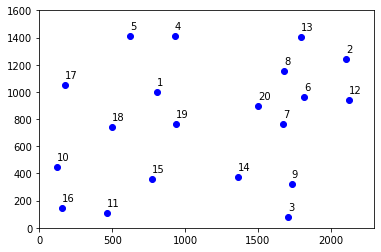

In [2]:
import matplotlib.pyplot as plt

xs = []
ys= []
for node,(x,y) in nodes.items():
    xs.append(x)
    ys.append(y)
    plt.text( x, y+50, node) # adds node label
plt.xlim( (0,xmax) )
plt.ylim( (0,ymax) )
plt.plot(xs,ys,"bo"); # adds a dot for each node

For the _cost_ of travelling from node `n1` to node `n2` we take the planar (straight-line Euclidean) distance.

In [3]:
def cost(n1,n2) :
    x1,y1 = nodes[n1]
    x2,y2 = nodes[n2]
    c = (x2-x1)**2 + (y2-y1)**2
    return c ** 0.5

The `cost()` function is symmetrical in `n1` and `n2`, and the 11..16 distance seems reasonable looking at the x-axis.

In [4]:
print( cost(11,16) )
print( cost(16,11) )

313.1932310890515
313.1932310890515


The 11..16 distance seems cose to the 4..5 distance, and 10..15 seems twice as long.

In [5]:
print( cost(4,5) )
print( cost(10,15) )

311.01446911679204
660.8638286364295


The `cost()` function (and some data points) are looking good.

## Linear programming
Next step is to model the nodes and cost as a linear programming problem.

In [6]:
import pulp

In [7]:
prob = pulp.LpProblem("tsp", pulp.LpMinimize)

The `edges` list encodes the _undirected_ edges between nodes `n1` and `n2`.

In [8]:
edges = [ (n1,n2) for n1 in nodes for n2 in nodes if n1<n2 ]
len(edges)

190

We will assign an edge a 1 when it is part of the tour and a 0 when it is not.
In other words we have a 0/1 variable per edge.

In [9]:
assign = pulp.LpVariable.dicts( "assign", edges, lowBound=0, upBound=1 )

The cost we need to minimize is the cost of the tour, i.e. the cost of the edges we include.

In [10]:
prob += pulp.lpSum( [assign[(n1,n2)]*cost(n1,n2) for (n1,n2) in edges ] )

Each node must have exactly two of its connected edges assigned.

In [11]:
for n in nodes :
    prob += pulp.lpSum( [assign[(n1,n2)] for (n1,n2) in edges if n1==n or n2==n ] ) == 2 , f"{n} twice"

The model is complete, we save and view it.

In [12]:
prob.writeLP("tsp1.lp")
!type tsp1.lp

\* tsp *\
Minimize
OBJ: 877.544870648 assign_(1,_10) + 950.648725871 assign_(1,_11)
 + 1322.14447017 assign_(1,_12) + 1068.38663414 assign_(1,_13)
 + 834.200215776 assign_(1,_14) + 641.848891874 assign_(1,_15)
 + 1071.8717274 assign_(1,_16) + 635.05117904 assign_(1,_17)
 + 403.094281775 assign_(1,_18) + 264.690385167 assign_(1,_19)
 + 1323.07067083 assign_(1,_2) + 702.300505482 assign_(1,_20)
 + 1284.8988287 assign_(1,_3) + 435.721241162 assign_(1,_4)
 + 455.597410001 assign_(1,_5) + 1012.67615752 assign_(1,_6)
 + 897.762774902 assign_(1,_7) + 889.508291136 assign_(1,_8)
 + 1145.09824906 assign_(1,_9) + 485.083497967 assign_(10,_11)
 + 2067.15867799 assign_(10,_12) + 1927.252189 assign_(10,_13)
 + 1246.25880137 assign_(10,_14) + 660.863828636 assign_(10,_15)
 + 305.895406961 assign_(10,_16) + 599.437236081 assign_(10,_17)
 + 474.489199034 assign_(10,_18) + 876.915047197 assign_(10,_19)
 + 1451.87774967 assign_(10,_20) + 1859.51418387 assign_(11,_12)
 + 1856.30196897 assign_(11,_13) + 9

In [13]:
prob.solve()
print( f"Solution is {pulp.LpStatus[prob.status]} with cost {pulp.value(prob.objective):.0f}" )

Solution is Optimal with cost 7045


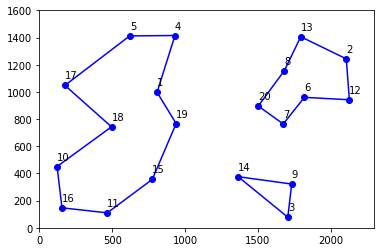

In [14]:
plt.xlim( (0,xmax) )
plt.ylim( (0,ymax) )
# Plot all nodes
xs = []
ys= []
for node,(x,y) in nodes.items():
    xs.append(x)
    ys.append(y)
    plt.text( x, y+50, node) # adds node label
plt.plot(xs,ys,"bo"); # adds a dot for each node
# Plot all assigned edges
for edge,var in assign.items():
    if var.value() : # edge assigned to tour?
        n1,n2= edge
        xs = [ nodes[n1][0], nodes[n2][0] ]
        ys = [ nodes[n1][1], nodes[n2][1] ]
        plt.plot( xs, ys, "b-" ) # adds edge (if assigned to tour)

This is the same solution as in the [book Opt Art by Robert Bosch](https://www.amazon.com/Opt-Art-Mathematical-Optimization-Visual/dp/0691164061). His optimal length was different (67301), because our nodes map differs in scale.

## Not a tour

The above assignment is, of course, not the solution we are looking for: it is not a single tour. Instead, it consists of _three_ sub-tours. We could solve this generally, by adding constraints to `prob` that forbid sub-tours. However, the amount of sub-tours is large, in this case $2^{20}$ or 1 048 576. A more practical approach is suggested by Robert: add constraints for sub-tours once they emerge; the "whack-a-mole" approach.

Can we find the subtours in our solution?

This is the list of assigned edges.

In [15]:
[ edge for edge,var in assign.items() if var.value() ]

[(1, 4),
 (1, 19),
 (2, 12),
 (2, 13),
 (3, 9),
 (3, 14),
 (4, 5),
 (5, 17),
 (6, 7),
 (6, 12),
 (7, 20),
 (8, 13),
 (8, 20),
 (9, 14),
 (10, 16),
 (10, 18),
 (11, 15),
 (11, 16),
 (15, 19),
 (17, 18)]

The following function removes edges one by one until a (sub-) tour is completed (returns to start node). If edges remain, a second (sub-) tour is constructed, and so on.

In [16]:
def find_tours(assign) :
    tours = []
    remaining_edges = [ edge for edge,var in assign.items() if var.value() ]
    while remaining_edges : # there as still edges an thus (sub-)tours
        # Take a random edge as start of a (sub-)tour
        e = remaining_edges.pop()
        # Tour starts with node `e[0]` and edge `e[0]..e[1]`
        tour = [ e[0] ]
        # Loop with `n`
        n = e[1]
        while not n in tour: # Node `n` is not yet at start of `tour`
            # Find edge that starts from node `n`.
            es = [ e for e in remaining_edges if e[0]==n or e[1]==n ]
            assert len(es)==1, "every n should occur in two edges, incoming was removed"
            e = es[0]
            remaining_edges.remove(e)
            # Record step
            tour.append(n)
            # Get next node (nodes in edge `e` may be swapped)
            n = e[1] if e[0]==n else e[0]
        tours.append(tour)
    return tours

We use the function to produce a list of (sub-) tours of our assignment. We indeed find three sub-tours.

In [17]:
tours1 = find_tours(assign)
tours1

[[17, 18, 10, 16, 11, 15, 19, 1, 4, 5], [9, 14, 3], [8, 20, 7, 6, 12, 2, 13]]

We use the sub-tours to add sub-tour elimination constraints to our problem.

In [18]:
for tour in tours1 :
    es = [ (min(n1,n2),max(n1,n2)) for n1 in tour for n2 in nodes if not n2 in tour ]
    prob += pulp.lpSum( [assign[e] for e in es ] ) >= 2 , f"elim {tour}"

We now have an stage 2 model - more constraints. We save the new model.

In [19]:
prob.writeLP("tsp2.lp")
!type tsp2.lp

\* tsp *\
Minimize
OBJ: 877.544870648 assign_(1,_10) + 950.648725871 assign_(1,_11)
 + 1322.14447017 assign_(1,_12) + 1068.38663414 assign_(1,_13)
 + 834.200215776 assign_(1,_14) + 641.848891874 assign_(1,_15)
 + 1071.8717274 assign_(1,_16) + 635.05117904 assign_(1,_17)
 + 403.094281775 assign_(1,_18) + 264.690385167 assign_(1,_19)
 + 1323.07067083 assign_(1,_2) + 702.300505482 assign_(1,_20)
 + 1284.8988287 assign_(1,_3) + 435.721241162 assign_(1,_4)
 + 455.597410001 assign_(1,_5) + 1012.67615752 assign_(1,_6)
 + 897.762774902 assign_(1,_7) + 889.508291136 assign_(1,_8)
 + 1145.09824906 assign_(1,_9) + 485.083497967 assign_(10,_11)
 + 2067.15867799 assign_(10,_12) + 1927.252189 assign_(10,_13)
 + 1246.25880137 assign_(10,_14) + 660.863828636 assign_(10,_15)
 + 305.895406961 assign_(10,_16) + 599.437236081 assign_(10,_17)
 + 474.489199034 assign_(10,_18) + 876.915047197 assign_(10,_19)
 + 1451.87774967 assign_(10,_20) + 1859.51418387 assign_(11,_12)
 + 1856.30196897 assign_(11,_13) + 9

And solve it.

In [20]:
print( f"Solution is {pulp.LpStatus[prob.status]} with cost {pulp.value(prob.objective):.0f}" )
prob.solve()
print( f"Solution is {pulp.LpStatus[prob.status]} with cost {pulp.value(prob.objective):.0f}" )

Solution is Optimal with cost 7045
Solution is Optimal with cost 7524


Note that the new assignment is more costly - this always happens when adding constraints.

The assignment can be rendered graphically.

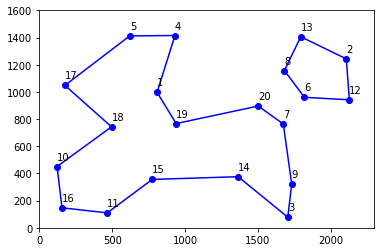

In [21]:
plt.xlim( (0,xmax) )
plt.ylim( (0,ymax) )
# Plot all nodes
xs = []
ys= []
for node,(x,y) in nodes.items():
    xs.append(x)
    ys.append(y)
    plt.text( x, y+50, node) # adds node label
plt.plot(xs,ys,"bo"); # adds a dot for each node
# Plot all assigned edges
for edge,var in assign.items():
    if var.value() : # edge assigned to tour?
        n1,n2= edge
        xs = [ nodes[n1][0], nodes[n2][0] ]
        ys = [ nodes[n1][1], nodes[n2][1] ]
        plt.plot( xs, ys, "b-" ) # adds edge (if assigned to tour)

This is the same stage 2 solution as Robert has in his book. Unfortunately, the 2nd stage is not the final one, there are again multiple (two) sub-tours.

In [22]:
tours2 = find_tours(assign)
tours2

[[19, 20, 7, 9, 3, 14, 15, 11, 16, 10, 18, 17, 5, 4, 1], [8, 13, 2, 12, 6]]

So we add those constraints as well - second round of whack-a-mole - and save the stage 3 problem.

In [23]:
for tour in tours2 :
    es = [ (min(n1,n2),max(n1,n2)) for n1 in tour for n2 in nodes if not n2 in tour ]
    prob += pulp.lpSum( [assign[e] for e in es ] ) >= 2 , f"elim {tour}"
prob.writeLP("tsp3.lp")
!type tsp3.lp    

\* tsp *\
Minimize
OBJ: 877.544870648 assign_(1,_10) + 950.648725871 assign_(1,_11)
 + 1322.14447017 assign_(1,_12) + 1068.38663414 assign_(1,_13)
 + 834.200215776 assign_(1,_14) + 641.848891874 assign_(1,_15)
 + 1071.8717274 assign_(1,_16) + 635.05117904 assign_(1,_17)
 + 403.094281775 assign_(1,_18) + 264.690385167 assign_(1,_19)
 + 1323.07067083 assign_(1,_2) + 702.300505482 assign_(1,_20)
 + 1284.8988287 assign_(1,_3) + 435.721241162 assign_(1,_4)
 + 455.597410001 assign_(1,_5) + 1012.67615752 assign_(1,_6)
 + 897.762774902 assign_(1,_7) + 889.508291136 assign_(1,_8)
 + 1145.09824906 assign_(1,_9) + 485.083497967 assign_(10,_11)
 + 2067.15867799 assign_(10,_12) + 1927.252189 assign_(10,_13)
 + 1246.25880137 assign_(10,_14) + 660.863828636 assign_(10,_15)
 + 305.895406961 assign_(10,_16) + 599.437236081 assign_(10,_17)
 + 474.489199034 assign_(10,_18) + 876.915047197 assign_(10,_19)
 + 1451.87774967 assign_(10,_20) + 1859.51418387 assign_(11,_12)
 + 1856.30196897 assign_(11,_13) + 9

Solution is Optimal with cost 7524
Solution is Optimal with cost 7628


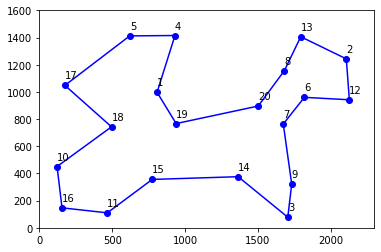

In [24]:
print( f"Solution is {pulp.LpStatus[prob.status]} with cost {pulp.value(prob.objective):.0f}" )
prob.solve()
print( f"Solution is {pulp.LpStatus[prob.status]} with cost {pulp.value(prob.objective):.0f}" )
plt.xlim( (0,xmax) )
plt.ylim( (0,ymax) )
# Plot all nodes
xs = []
ys= []
for node,(x,y) in nodes.items():
    xs.append(x)
    ys.append(y)
    plt.text( x, y+50, node) # adds node label
plt.plot(xs,ys,"bo"); # adds a dot for each node
# Plot all assigned edges
for edge,var in assign.items():
    if var.value() : # edge assigned to tour?
        n1,n2= edge
        xs = [ nodes[n1][0], nodes[n2][0] ]
        ys = [ nodes[n1][1], nodes[n2][1] ]
        plt.plot( xs, ys, "b-" ) # adds edge (if assigned to tour)

Finally, the `find_tours()` returns 1 tour, so we have a real TSP tour - the same as Robert.

In [25]:
tours3 = find_tours(assign)
tours3

[[19, 20, 8, 13, 2, 12, 6, 7, 9, 3, 14, 15, 11, 16, 10, 18, 17, 5, 4, 1]]

This concludes using _linear programming_ to solve a _travelling salesman_ problem (TSP) using the _whack-a-mole_ approach.
In our example graph, three iterations where needed, and we eliminated 5 sub-tours.

## Branch
In his book Robert has another "set of cities" that are not solvable with just the whack-a-mole approach. They result in assignments of 0.5 - instead of 0 or 1. Did not try yet.

(end)